
# Title
description

## Section 0 - imports, constants, and notebook set-up

In [1]:
# Library imports
### Utility
import os
from pathlib import Path
from utils import download_dataset, extract_dataset, compute_metrics, trainer_SC, evaluation_run, plot_data_map, Sentences_Dataset, hard_to_learn, synonyms, mostsimilar, cleanline
import urllib
import zipfile
import re

### Datascience
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

### Plotting
import matplotlib.pyplot as plt

# Nltk download
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/angelo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/angelo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/angelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/angelo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Set of constant used, you can choose which to use below
SEEDS = [42, 69, 420, 42069, 69420]
CARD_DICT = {"sentence":"sentence-transformers/bert-base-nli-mean-tokens",
             "legal":"nlpaueb/legal-bert-small-uncased",
             "tiny":"prajjwal1/bert-tiny"
            }

In [3]:
# Constant setting --- you can change these
SEED_IDX = 0
CARD_KEY = "tiny"
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
EPOCHS = 60
LEARNING_RATE = 2e-4

In [4]:
# Constant derivation settings --- DO NOT TOUCH
SEED = SEEDS[SEED_IDX]
CARD = CARD_DICT.get(CARD_KEY, "nlpaueb/legal-bert-small-uncased")
torch.manual_seed(SEED);
np.random.seed(SEED);

## Section 1 - Dataset(s) import & manipulation

### 1.1 - Glove Download

In [5]:
# GloVe embedding download
glove_url = "https://nlp.stanford.edu/data/glove.6B.zip"
glove_dir = "glove.6B"
if not os.path.isdir(os.path.join(os.getcwd(), glove_dir)):
    urllib.request.urlretrieve(glove_url, "glove.6B.zip")
    with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
        zip_ref.extractall("glove.6B")

    os.remove("glove.6B.zip")

print("GloVe embeddings downloaded and extracted.")

embeddings = {}

for file_name in os.listdir(glove_dir):
    file_path = os.path.join(glove_dir, file_name)

    with open(file_path, 'r', encoding="utf8") as f_glove:
        for line in f_glove:
            entries = line.split()
            wordvector = np.asarray(entries[1:], "float32")
            embeddings[entries[0]] = wordvector

GloVe embeddings downloaded and extracted.


### 1.2 - Import of demosthenes library

In [6]:
url = "https://github.com/engibengi/demosthenes/archive/main.zip"

dataset_name = "demosthenes-main"

dataset_zip_path = Path.cwd().joinpath("demosthenes-main.zip")
dataset_path = Path.cwd().joinpath(dataset_name)

if not dataset_zip_path.exists():
    download_dataset(dataset_zip_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_zip_path, Path.cwd())

### 1.3 - Conversion of xml to json & creation of .pkl datasets

In [7]:
%%capture
%cd ./$dataset_name
%run ./xmlToJson.py # Transform xml dataset into a json one using the dataset utilities
%run ./create_df.py # Create .pkl dataframe from dataset
%cd ./..

### 1.4 - import of .pkl datasets

In [8]:
annotations = pd.read_pickle(os.path.join(Path.cwd(), dataset_name, 'df_annotations.pkl'))
#sentences = pd.read_pickle(os.path.join(Path.cwd(), dataset_name, 'df_sentences.pkl'))

### 1.5 - Remove Non-Legal sentences

In [9]:
premises=annotations[annotations['Name']=='prem']
legal=premises[premises['Type']!='F']

### 1.6 - Creation of classes and labels in dataframe

In [10]:


legal = legal.copy()

# Function to convert lists to strings
def convert_to_string(value):
    if isinstance(value, list):
        return ','.join(value)
    else:
        return value

# Apply the function to the 'Target' column
legal['Scheme'] = legal['Scheme'].apply(convert_to_string)


legal = legal.copy()
legal.dropna(subset=['Scheme'], inplace=True)
# Create an instance of MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# Fit and transform the 'Type' column
transformed_labels = mlb.fit_transform(legal['Scheme'].str.split(','))


#add new columns to the dataframe

for col,name in enumerate(mlb.classes_):
    legal[name]=transformed_labels[:,col]

legal, test_l = train_test_split(legal, test_size = 0.4)

legal.reset_index(drop=True, inplace=True)
test_l.reset_index(drop=True, inplace=True)

In [11]:
labels=[i for i in mlb.classes_]

## Section 2 - Model(s) import & set-up

In [12]:
tokenizer = AutoTokenizer.from_pretrained(CARD)
model = AutoModelForSequenceClassification.from_pretrained(CARD, num_labels = len(labels), problem_type='multi_label_classification')
for param in model.bert.embeddings.parameters():
    param.requires_grad = False
for param in model.bert.encoder.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer.zero_grad()
loss_fn = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Section 3 - Model(s) training

In [13]:
dataset = Sentences_Dataset(legal, tokenizer, labels, max_len=MAX_LEN)
test_dataset = Sentences_Dataset(test_l, tokenizer, labels, max_len=MAX_LEN)
loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, pin_memory=True)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

In [15]:
train_dyn = {}

### Training

In [16]:
history = trainer_SC(model, device, optimizer, loss_fn, loader, EPOCHS*3, train_dyn)

EPOCH 1/180...
Generation of samples for data cartography...
EPOCH 2/180...
Generation of samples for data cartography...
EPOCH 3/180...
Generation of samples for data cartography...
EPOCH 4/180...
Generation of samples for data cartography...
EPOCH 5/180...
Generation of samples for data cartography...
EPOCH 6/180...
Generation of samples for data cartography...
EPOCH 7/180...
Generation of samples for data cartography...
EPOCH 8/180...
Generation of samples for data cartography...
EPOCH 9/180...
Generation of samples for data cartography...
EPOCH 10/180...
Generation of samples for data cartography...
EPOCH 11/180...
Generation of samples for data cartography...
EPOCH 12/180...
Generation of samples for data cartography...
EPOCH 13/180...
Generation of samples for data cartography...
EPOCH 14/180...
Generation of samples for data cartography...
EPOCH 15/180...
Generation of samples for data cartography...
EPOCH 16/180...
Generation of samples for data cartography...
EPOCH 17/180...
G

## Section 4 - Model(s) evaluation

In [17]:
model.eval()
results = evaluation_run(model, test_loader, device)
results = pd.DataFrame(results, columns=labels)
print(classification_report(test_l[labels], results, target_names=labels, zero_division=0.0))

              precision    recall  f1-score   support

         Aut       0.00      0.00      0.00         6
       Class       0.88      0.29      0.44        24
        Itpr       0.60      0.54      0.57       102
        Prec       0.97      0.75      0.85       215
       Princ       0.00      0.00      0.00         9
        Rule       0.85      0.49      0.62       119

   micro avg       0.84      0.59      0.70       475
   macro avg       0.55      0.35      0.41       475
weighted avg       0.83      0.59      0.68       475
 samples avg       0.81      0.66      0.71       475



## Section 5 - PLOT DATA CARTOGRAHPY

In [18]:
cartography = compute_metrics(train_dyn)
legal = legal.join(cartography)

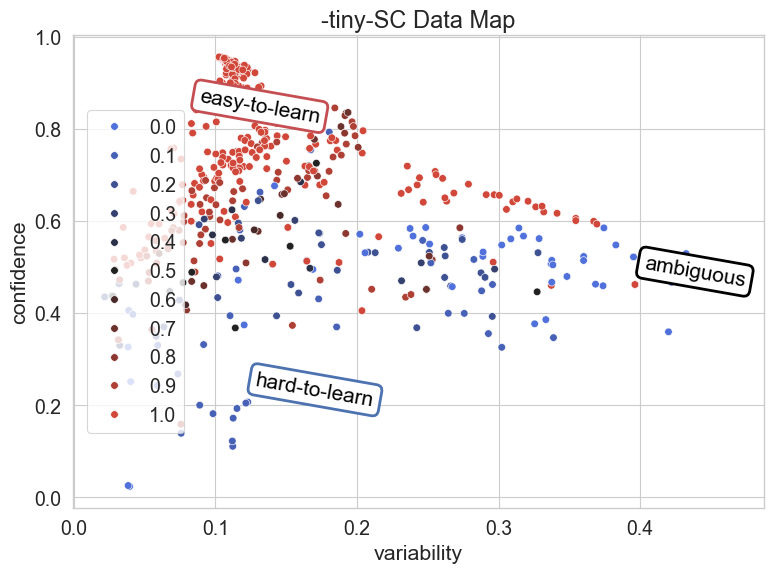

In [19]:
plot_data_map(cartography,plot_dir=os.getcwd(),show_hist=False, model=CARD_KEY+"-SC")

## Section 6 - Curriculum Learning

In [20]:
new_col = pd.DataFrame(legal['confidence'] * (1 - legal['variability']), columns = ['c*(1-v)'])
legal = legal.join(new_col)
datasets_curriculum = [
    legal[legal['c*(1-v)'] >= legal['c*(1-v)'].quantile(i/10)].reset_index(drop=True, inplace=False)
    for i in range(9, -1, -1)
    ]
datasets_curriculum = [Sentences_Dataset(ds, tokenizer, labels, max_len=MAX_LEN) for ds in datasets_curriculum]
loaders_curriculum = [DataLoader(ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True) for ds in datasets_curriculum]

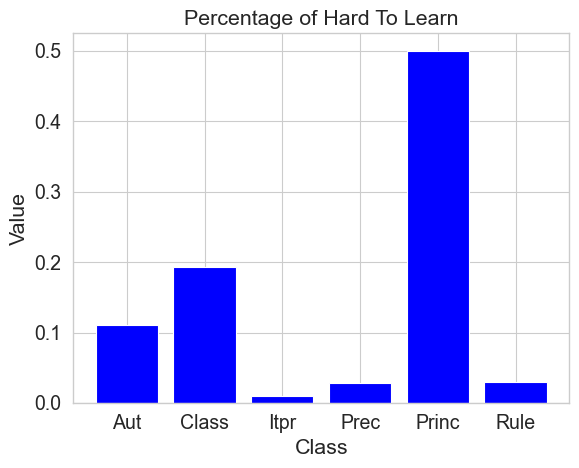

In [21]:
hard_to_learn(legal, labels)

### Create the new model

In [22]:
model2 = AutoModelForSequenceClassification.from_pretrained(CARD, num_labels = len(labels), problem_type='multi_label_classification')
for param in model2.bert.embeddings.parameters(): # We don't want to train the first layer
    param.requires_grad = False
for param in model2.bert.encoder.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model2.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer.zero_grad()
loss_fn = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model2.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

### Train with curriculum learning

In [24]:
history2 = []
train_dyn2 = {}
for i,loader in enumerate(loaders_curriculum):
    history2.extend(trainer_SC(model2, device, optimizer, loss_fn, loader, EPOCHS//((11-i)//2), train_dyn2))

EPOCH 1/12...
Generation of samples for data cartography...
EPOCH 2/12...
Generation of samples for data cartography...
EPOCH 3/12...
Generation of samples for data cartography...
EPOCH 4/12...
Generation of samples for data cartography...
EPOCH 5/12...
Generation of samples for data cartography...
EPOCH 6/12...
Generation of samples for data cartography...
EPOCH 7/12...
Generation of samples for data cartography...
EPOCH 8/12...
Generation of samples for data cartography...
EPOCH 9/12...
Generation of samples for data cartography...
EPOCH 10/12...
Generation of samples for data cartography...
EPOCH 11/12...
Generation of samples for data cartography...
EPOCH 12/12...
Generation of samples for data cartography...
EPOCH 1/12...
Generation of samples for data cartography...
EPOCH 2/12...
Generation of samples for data cartography...
EPOCH 3/12...
Generation of samples for data cartography...
EPOCH 4/12...
Generation of samples for data cartography...
EPOCH 5/12...
Generation of samples f

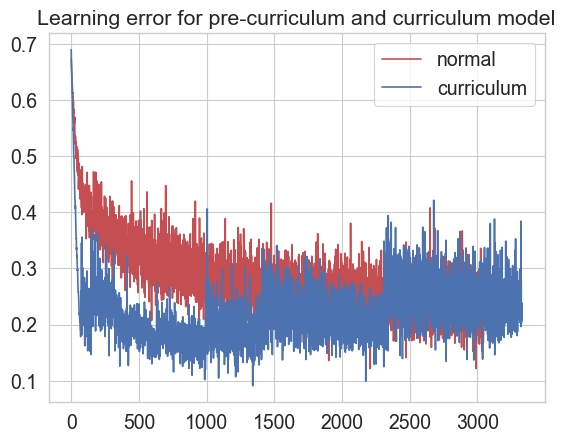

In [25]:
plt.plot(history, c='r')
plt.plot(history2, c='b')
plt.title("Learning error for pre-curriculum and curriculum model")
plt.legend(['normal', 'curriculum'])
plt.grid(True)
plt.show();

In [26]:
results2 = evaluation_run(model2, test_loader, device)
results2 = pd.DataFrame(results2, columns=labels)
print(classification_report(test_l[labels], results2, target_names=labels, zero_division=0.0))

              precision    recall  f1-score   support

         Aut       0.00      0.00      0.00         6
       Class       1.00      0.25      0.40        24
        Itpr       0.62      0.52      0.57       102
        Prec       0.96      0.79      0.86       215
       Princ       0.00      0.00      0.00         9
        Rule       0.85      0.49      0.62       119

   micro avg       0.85      0.60      0.71       475
   macro avg       0.57      0.34      0.41       475
weighted avg       0.83      0.60      0.69       475
 samples avg       0.82      0.67      0.71       475



## Section 7 - Data Augmentation on hard to learn

In [27]:
filtered_dfsc = legal[(legal['c*(1-v)']<=0.5)]

# Extract the 'Text' column from the filtered DataFrame
text_column_sc = filtered_dfsc['Text'].reset_index(drop=True)
conf_column_sc = filtered_dfsc['confidence'].reset_index(drop=True)
var_column_sc = filtered_dfsc['variability'].reset_index(drop=True)
corr_column_sc = filtered_dfsc['correctness'].reset_index(drop=True)
cv_column_sc = filtered_dfsc['c*(1-v)'].reset_index(drop=True)
type_column_sc = filtered_dfsc['Type'].reset_index(drop=True)
scheme_column_sc = filtered_dfsc['Scheme'].reset_index(drop=True)
aut_column_sc = filtered_dfsc['Aut'].reset_index(drop=True)
class_column_sc = filtered_dfsc['Class'].reset_index(drop=True)
itpr_column_sc = filtered_dfsc['Itpr'].reset_index(drop=True)
prec_column_sc = filtered_dfsc['Prec'].reset_index(drop=True)
princ_column_sc = filtered_dfsc['Princ'].reset_index(drop=True)
rule_column_sc = filtered_dfsc['Rule'].reset_index(drop=True)

text_column_sc.to_csv('output_sc.txt', index=False, header=False, sep='\t')

TRAINSETPATHX=str(Path.cwd().joinpath('output_sc.txt'))

f=open(TRAINSETPATHX,'r',encoding='utf8')
maximbits_sc=f.readlines()
f.close()
#removing the endline characters
maximbits_sc=[maxim[:-1] for maxim in maximbits_sc]

print("The number of maxims for sc: {}".format(len(maximbits_sc)))

The number of maxims for sc: 200


In [28]:
#breaking th maxim lines into sentences
sentences_sc = []
nsentence_sc = []  #storing the number of sentences each maxim contains
for line in maximbits_sc:
    count = 0
    #splitting sentences using ". " characters
    #listsent=line.replace('\\\n','').split('. ')
    listsent = line.split('. ')
    for i in range(0, len(listsent)):
        sentence_sc = listsent[i]
        #sentences that are too short are eliminated
        if len(sentence_sc) < 5:
            continue
        elif (i == len(listsent) - 1):
            #the last one is added as it is since we used the character sequence ". " for the seperation
            #and the last sentence contains only "."
            sentences_sc.append(sentence_sc)
            count = count + 1
            continue
        else:
            #the "." characters are restored
            if (sentence_sc[-1] != '.'):
                sentence_sc = sentence_sc + '.'
            sentences_sc.append(sentence_sc)
            count = count + 1
    nsentence_sc.append(count)

print(len(sentences_sc))
print(len(nsentence_sc))

200
200


In [29]:
perfix=[0.6] #percentage desired
noisesent6=[]
S=[]
Nord=3
L=len(legal)
for ord in range(Nord):
  for sent in sentences_sc:
      if sentences_sc.index(sent)%100==0:
          print(sentences_sc.index(sent))
      #tokinizing and capitalizing the sentences
      tokens = nltk.word_tokenize(cleanline(sent).capitalize())
      #lower-casing the tokens
      tokens=[token.lower() for token in tokens]
      #eliminating the stop words
      nonstoptoken = [word for word in tokens if not word in stop_words]
      tags = nltk.pos_tag(nonstoptoken)
      #collecting the tokens with POS tag in categories nouns, adjectives and adverbs
      tochange=[tag for tag in tags if tag[1][0] in ['J','N','R']]
      nchange=[round(per*len(tochange)) for per in perfix] #number of required replacements due to the percentage given
      #print("Len to change: {}".format(len(tochange)))
      #print("Nchange: {}".format(nchange[0]))
      linemodtotal=sent.lower()
      indicator=sent[0].isupper()
      changed=0
      #adding the sentences into list if no change is supposed to be performed
      if nchange[0]==0:
          if (indicator):
              toadd=linemodtotal.capitalize()
          else:
              toadd=linemodtotal
          noisesent6.append(toadd)
      index=-1
      #the replacement order of the tokens could also be randomized by making the following line uncommented
      #random.shuffle(tochange)
      while(changed<nchange[-1]):
          index+=1
          if(index==len(tochange)):
              if changed<nchange[0]:
                if (indicator):
                    toadd=linemodtotal.replace('#','').capitalize()
                else:
                    toadd=linemodtotal.replace('#','')
                noisesent6.append(toadd)
                #print(toadd)
              break
          word=tochange[index][0]
          #print("Word to change: {}".format(word))
          #Obtaining the candidates for the replacement
          [wn,check2]=synonyms(tochange[index][0],10)
          #if the list is not empty:
          if (check2):
              toreplace=mostsimilar(embeddings,word,wn, order=ord)
              #print("TOREPLACE: {}".format(toreplace))
              #word is replaced with the candidate accompanying "#" characters as boundaries
              #this is done to prevent the replacement of the in-word and multiple occurences of the words in process
              pattern='(?<![a-zA-Z#])'+word+'(?![a-zA-Z#])'
              linemodtotal=re.sub(pattern,'#'+toreplace+'#',linemodtotal,1)
              #print(linemodtotal)
              changed+=1
          else:
              continue
          #if the desired number of words are replaced
          if changed==nchange[0]:
              #indicator serves as a sign of the capitalized sentence
              #the "#" characters are removed at the end
              if (indicator):
                  toadd=linemodtotal.replace('#','').capitalize()
              else:
                  toadd=linemodtotal.replace('#','')
              #the augmented sentences added to the list defined at the beginning
              noisesent6.append(toadd)
              break

0
100
0
100
0
100


In [30]:
#the path where the document containing the augmented samples will be saved to
FINALPATH=str(Path.cwd())

noiselist=[noisesent6]
for element in noiselist:
    folder="0.6" #Could also be iterated due to percentages. Here we use only one percentage value therefore it is strictly defined
    final=[]
    start=0
    for i in range(0,len(nsentence_sc)):
        toaddm=''
        n=nsentence_sc[i]
        #merging the sentences that are contained in the same maxim
        for j in range(start,start+n):
            toaddm=toaddm+' '+element[j]
        toaddm=toaddm[1:]
        final.append(toaddm)
        start=start+n
    #saving the augmented samples into a text document in the given final path
    f=open(FINALPATH+'/maximsamples_wordnetglove_sc'+folder[-1]+'0.txt', 'w',encoding="utf8")
    for line in final:
        f.write(line+'\n')
    f.close()

txt_file_path = "maximsamples_wordnetglove_sc60.txt"

with open(txt_file_path, 'r', encoding='utf-8') as file:
    new_texts = file.readlines()
conf_column_ac = conf_column_sc.reset_index(drop=True)
var_column_ac = var_column_sc.reset_index(drop=True)
corr_column_ac = corr_column_sc.reset_index(drop=True)
cv_column_ac = cv_column_sc.reset_index(drop=True)
for k in range(len(new_texts)):
    new_row = pd.DataFrame({
        #'ID': [len(legal)+k],
        'Document': ['new'],
        'Split': [1],
        'Name': ['prem'],
        'Id': ['new'],
        'Text': [new_texts[k]],
        'Type': [type_column_sc[k%len(sentences_sc)]],
        'Scheme': [scheme_column_sc[k%len(sentences_sc)]],
        'Aut': [aut_column_sc[k%len(sentences_sc)]],
        'Class': [class_column_sc[k%len(sentences_sc)]],
        'Itpr': [itpr_column_sc[k%len(sentences_sc)]],
        'Prec': [prec_column_sc[k%len(sentences_sc)]],
        'Princ': [princ_column_sc[k%len(sentences_sc)]],
        'Rule': [rule_column_sc[k%len(sentences_sc)]],
        'confidence': [conf_column_sc[k%len(sentences_sc)]],
        'variability': [var_column_sc[k%len(sentences_sc)]],
        'correctness': [corr_column_sc[k%len(sentences_sc)]],
        'c*(1-v)': [cv_column_ac[k%len(sentences_sc)]]
    })
    legal = pd.concat([legal, new_row], ignore_index=True)

legal.to_pickle("updated_df_sc.pkl")

In [31]:
datasets_curriculum = [
    legal[legal['c*(1-v)'] >= legal['c*(1-v)'].quantile(i/10)].reset_index(drop=True, inplace=False)
    for i in range(9, -1, -1)
    ]
datasets_curriculum = [Sentences_Dataset(ds, tokenizer, labels, max_len=MAX_LEN) for ds in datasets_curriculum]
loaders_curriculum = [DataLoader(ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True) for ds in datasets_curriculum]

## Section 8 - Model with Data Augmentation and curriculum learning

In [32]:
model3 = AutoModelForSequenceClassification.from_pretrained(CARD, num_labels = len(labels), problem_type='multi_label_classification')
for param in model3.bert.embeddings.parameters(): # We don't want to train the first layer
    param.requires_grad = False
for param in model3.bert.encoder.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model3.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer.zero_grad()
loss_fn = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model3.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

In [34]:
history3 = []
train_dyn3 = {}
for i,loader in enumerate(loaders_curriculum):
    history3.extend(trainer_SC(model3, device, optimizer, loss_fn, loader, EPOCHS//((11-i)//2), train_dyn3))

EPOCH 1/12...
Generation of samples for data cartography...
EPOCH 2/12...
Generation of samples for data cartography...
EPOCH 3/12...
Generation of samples for data cartography...
EPOCH 4/12...
Generation of samples for data cartography...
EPOCH 5/12...
Generation of samples for data cartography...
EPOCH 6/12...
Generation of samples for data cartography...
EPOCH 7/12...
Generation of samples for data cartography...
EPOCH 8/12...
Generation of samples for data cartography...
EPOCH 9/12...
Generation of samples for data cartography...
EPOCH 10/12...
Generation of samples for data cartography...
EPOCH 11/12...
Generation of samples for data cartography...
EPOCH 12/12...
Generation of samples for data cartography...
EPOCH 1/12...
Generation of samples for data cartography...
EPOCH 2/12...
Generation of samples for data cartography...
EPOCH 3/12...
Generation of samples for data cartography...
EPOCH 4/12...
Generation of samples for data cartography...
EPOCH 5/12...
Generation of samples f

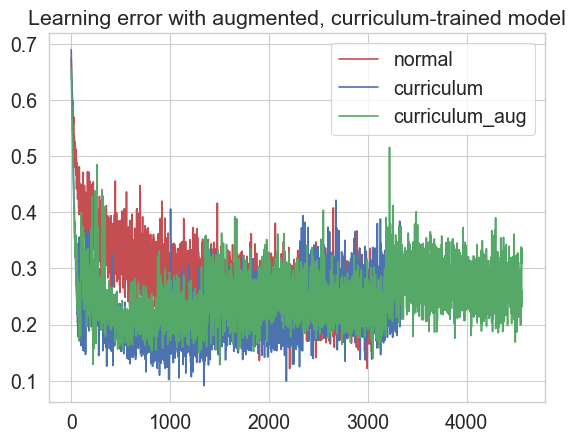

In [35]:
plt.plot(history, c='r')
plt.plot(history2, c='b')
plt.plot(history3, c='g')
plt.legend(['normal', 'curriculum', 'curriculum_aug'])
plt.title("Learning error with augmented, curriculum-trained model")
plt.grid(True)
plt.show();

In [42]:
results3 = evaluation_run(model3, test_loader, device)
results3 = pd.DataFrame(results3, columns=labels)
print(classification_report(test_l[labels], results3, target_names=labels, zero_division=0.0))

              precision    recall  f1-score   support

         Aut       0.00      0.00      0.00         6
       Class       0.88      0.29      0.44        24
        Itpr       0.63      0.49      0.55       102
        Prec       0.96      0.76      0.85       215
       Princ       0.00      0.00      0.00         9
        Rule       0.87      0.50      0.63       119

   micro avg       0.86      0.59      0.70       475
   macro avg       0.56      0.34      0.41       475
weighted avg       0.83      0.59      0.68       475
 samples avg       0.80      0.65      0.70       475



## Section 9 - Model with only Data Augmentation

In [37]:
model4 = AutoModelForSequenceClassification.from_pretrained(CARD, num_labels = len(labels), problem_type='multi_label_classification')
for param in model4.bert.embeddings.parameters(): # We don't want to train the first layer
    param.requires_grad = False
for param in model4.bert.encoder.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model4.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer.zero_grad()
loss_fn = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
dataset_aug = Sentences_Dataset(legal, tokenizer, labels, max_len=MAX_LEN)
loader_aug = DataLoader(dataset_aug, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)

In [39]:
train_dyn4 = {}
history4 = trainer_SC(model4, device, optimizer, loss_fn, loader, EPOCHS*3, train_dyn4)

EPOCH 1/180...
Generation of samples for data cartography...
EPOCH 2/180...
Generation of samples for data cartography...
EPOCH 3/180...
Generation of samples for data cartography...
EPOCH 4/180...
Generation of samples for data cartography...
EPOCH 5/180...
Generation of samples for data cartography...
EPOCH 6/180...
Generation of samples for data cartography...
EPOCH 7/180...
Generation of samples for data cartography...
EPOCH 8/180...
Generation of samples for data cartography...
EPOCH 9/180...
Generation of samples for data cartography...
EPOCH 10/180...
Generation of samples for data cartography...
EPOCH 11/180...
Generation of samples for data cartography...
EPOCH 12/180...
Generation of samples for data cartography...
EPOCH 13/180...
Generation of samples for data cartography...
EPOCH 14/180...
Generation of samples for data cartography...
EPOCH 15/180...
Generation of samples for data cartography...
EPOCH 16/180...
Generation of samples for data cartography...
EPOCH 17/180...
G

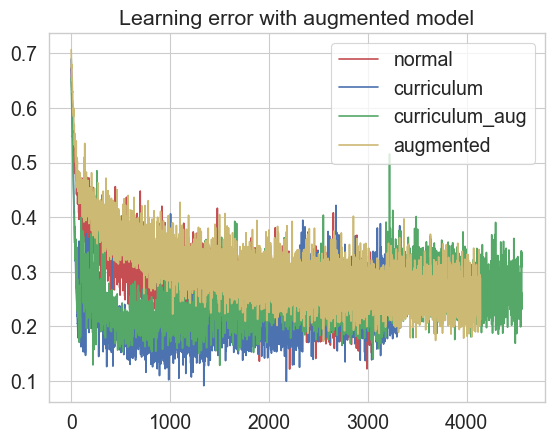

In [40]:
plt.plot(history, c='r')
plt.plot(history2, c='b')
plt.plot(history3, c='g')
plt.plot(history4, c='y')
plt.legend(['normal', 'curriculum', 'curriculum_aug', 'augmented'])
plt.title("Learning error with augmented model")
plt.grid(True)
plt.show();

In [41]:
results4 = evaluation_run(model4, test_loader, device)
results4 = pd.DataFrame(results4, columns=labels)
print(classification_report(test_l[labels], results4, target_names=labels, zero_division=0.0))

              precision    recall  f1-score   support

         Aut       0.00      0.00      0.00         6
       Class       0.88      0.29      0.44        24
        Itpr       0.64      0.51      0.57       102
        Prec       0.95      0.77      0.85       215
       Princ       0.00      0.00      0.00         9
        Rule       0.88      0.49      0.63       119

   micro avg       0.86      0.60      0.70       475
   macro avg       0.56      0.34      0.41       475
weighted avg       0.83      0.60      0.69       475
 samples avg       0.81      0.67      0.71       475

